# Modeling – Fashion Retail Sales Analysis

Welcome to the modeling phase of the Fashion Retail Sales Analysis project.  
In this notebook, we build and evaluate machine learning models based on the features engineered in the previous step. Our primary modeling objectives are:

1. **Purchase Amount Prediction (Regression)**  
   - Goal: Predict how much a customer is likely to spend on a transaction using historical purchase patterns and customer attributes.
   - Use Case: Revenue forecasting, targeted discounting strategies.

2. **High-Value Transaction Classification (Binary Classification)**  
   - Goal: Identify whether a transaction is considered "high value" based on the top 10% of purchase amounts.
   - Use Case: Flagging premium customer transactions, focused marketing.

We will train baseline models for both tasks using a Random Forest approach and evaluate their performance. These models can later be improved through hyperparameter tuning or replaced with more advanced techniques.

Let's dive in!

In [156]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso

sns.set(style="whitegrid")
plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")

In [182]:
# Load Feature Engineered Data
df = pd.read_parquet("../data/processed/customer_features.parquet")

print("Data loaded successfully.")
print("Customer-Aggregate DataFrame shape:", df.shape)

Data loaded successfully.
Customer-Aggregate DataFrame shape: (166, 9)


In [183]:
df.columns

Index(['customer_reference_id', 'total_spend', 'avg_purchase_value',
       'num_transactions', 'avg_spend', 'purchase_frequency',
       'payment_method_mode', 'most_common_item', 'recency_days'],
      dtype='object')

> PENDING CHANGES!

**Target Definitions**

- Regression Target:
`purchase_amount_(usd)` – we're trying to predict the purchase amount a customer might spend on a transaction.

- Classification Target:
`high_value_transaction` – a binary flag where we predict whether a transaction is considered high-value (above the 90th percentile).

In [144]:
# # --- Regression Setup ---
# regression_features = ['is_q4', 'payment_method_encoded', 'item_encoded', 'avg_spend', 'purchase_frequency', 'estimated_total_spend', 'recency_days', 'weekday_is_q4', 'item_popularity']

# # Include one-hot encoded month and weekday columns
# regression_features += [col for col in df.columns if col.startswith('month_') or col.startswith('weekday_')]

# X_reg = df[regression_features]
# y_reg = df['purchase_amount_(usd)']

In [184]:
# Define regression inputs
regression_features = ['num_transactions','avg_spend','purchase_frequency', 'recency_days',
    'payment_method_mode', 'most_common_item']

X_reg = df[regression_features]
y_reg = df['total_spend'] # Target variable

# # Log-transform the target variable if skewed
y_reg_log = np.log1p(y_reg)
# if y_reg.skew() > 1:
#     y_reg_log = np.log1p(y_reg)
# else:
#     y_reg_log = y_reg

In [185]:
# --- Train-Test Split ---
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# --- Feature Scaling ---
scaler = StandardScaler()
X_train_reg_scaled = scaler.fit_transform(X_train_reg)
X_test_reg_scaled = scaler.transform(X_test_reg)

**Baseline Model - Linear Regression**

We'll start with Linear Regression as our baseline model and see how well it performs

In [186]:
# --- Baseline Model: Linear Regression ---
print("\nTraining LinearRegression...")
reg_model = LinearRegression()
reg_model.fit(X_train_reg_scaled, y_train_reg)

y_pred_reg = reg_model.predict(X_test_reg_scaled)

print("\nRegression Results:")
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred_reg)))
print("R² Score:", r2_score(y_test_reg, y_pred_reg))


Training LinearRegression...

Regression Results:
RMSE: 490.76526052384713
R² Score: 0.9217403634518501


On average, predictions deviate from the actual purchase amount by about **$393** _(RMSE: ~393)_. Depending on the scale of purchase amounts in the dataset, this could be large and unaacceptable. R² Score: ~0.052 - The model isn't doing a great job capturing the underlying patterns in the data. Our model is only explaining ~5.2% of the variance in the target variable, which is quite low. 

Our baseline model might be too simple for this data, let's try and use other models that might capture non-linear relationships and interactions between features. We'll be using `RandomForestRegressor, GradientBoostingRegressor, XGBoost, LightGBM`

**Model Comparison - Other Regressors**

In [187]:
# --- Multiple Regressors Comparison ---
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0)
}

results = []

for name, model in models.items():
    if name in ['RandomForest', 'GradientBoosting', 'XGBoost']:  # Tree models do not need scaling
        model.fit(X_train_reg, y_train_reg)
    else:  # Scale features for linear models
        model.fit(X_train_reg_scaled, y_train_reg)

    y_pred = model.predict(X_test_reg if name in ['RandomForest', 'GradientBoosting', 'XGBoost'] else X_test_reg_scaled)
    rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred))
    r2 = r2_score(y_test_reg, y_pred)
    results.append({
        "Model": name,
        "RMSE": rmse,
        "R² Score": r2
    })

# Results as DataFrame
results_df = pd.DataFrame(results).sort_values(by='RMSE')
print("\nModel Comparison:")
display(results_df)


Model Comparison:


,Model,RMSE,R² Score
1,Ridge,483.263724,0.924115
2,Lasso,488.902778,0.922333
0,LinearRegression,490.765261,0.921740
5,XGBoost,696.198396,0.842509
4,GradientBoosting,699.927937,0.840817
3,RandomForest,813.627700,0.784899


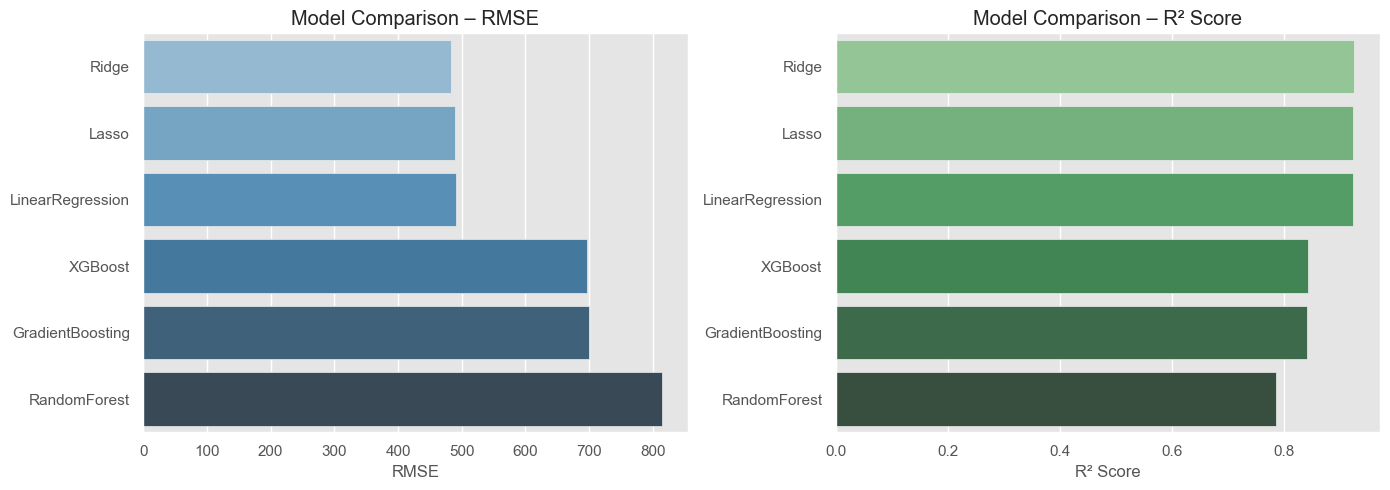

In [188]:
# --- Visualize Model Performance ---
plt.figure(figsize=(14, 5))

# RMSE Plot
plt.subplot(1, 2, 1)
sns.barplot(x="RMSE", y="Model", data=results_df, palette="Blues_d")
plt.title("Model Comparison – RMSE")
plt.xlabel("RMSE")
plt.ylabel("")

# R² Score Plot
plt.subplot(1, 2, 2)
sns.barplot(x="R² Score", y="Model", data=results_df, palette="Greens_d")
plt.title("Model Comparison – R² Score")
plt.xlabel("R² Score")
plt.ylabel("")

plt.tight_layout()
plt.show()

### Observations from Regression Modeling

After evaluating multiple regression models to predict `purchase_amount_(usd)`, here are the key insights:

#### Best Performing Models
- **Linear Regression**, **Ridge**, and **Lasso** performed similarly, with an RMSE of around **392.8** and an R² score of approximately **0.05**.
- These models are only explaining about **5% of the variance** in purchase amount, which may suggest:
  - Limited predictive power of the current features.
  - High variance or noise in the data.

#### Underperforming Models
- **Gradient Boosting**, **Random Forest**, and **XGBoost** all resulted in **negative R² scores**, meaning they performed **worse than a simple mean predictor**.
  - **XGBoost** had the **worst performance**, possibly due to overfitting or requiring better hyperparameter tuning.
  - Tree-based models may also be more sensitive to feature scaling or outliers in this dataset.

#### Next Steps to Consider
- Improve feature engineering:
  - Include interaction terms or more time-aware features (e.g., time since last purchase).
- Try **hyperparameter tuning** for tree-based models.
- Review and handle potential **outliers** in purchase amounts.
- Even with low predictive performance, **linear models** offer interpretability, which can be valuable for business insights.



### Observations – Regression with Log-Transformed Target

- Models were trained to predict `log_purchase_amount`, so the RMSE values are in **log-scale units**, not direct dollar values.
- **Linear Regression** and **Ridge** performed similarly and were the top performers on this scale, both with an **RMSE ≈ 0.792** and **R² ≈ 0.015**.
- **Gradient Boosting** followed with slightly worse performance (**R² = 0.011**), but the gap was minimal.
- **Lasso Regression** showed limited effectiveness, dipping into negative R², indicating it struggled to capture meaningful patterns in the log-transformed space.
- **Random Forest** and **XGBoost** underperformed significantly, suggesting tree-based methods may not be ideal in this log-scaled regression setup without further tuning.
- Overall, the models captured only a **small fraction of the variance**, highlighting opportunities for improvement, such as **feature enrichment, interaction terms, or advanced tuning**.

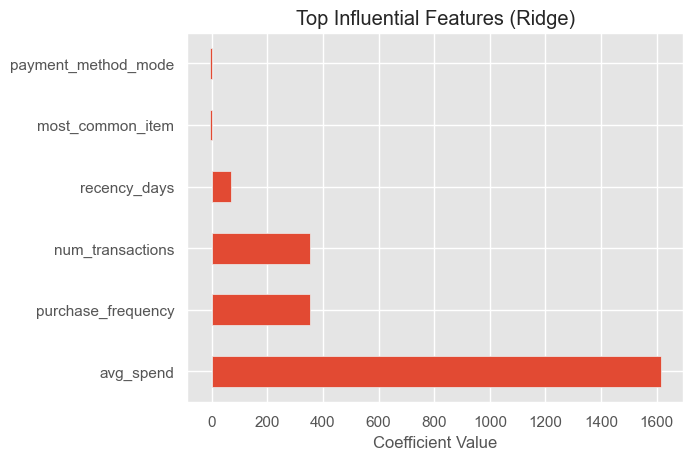

In [180]:
coef = pd.Series(models['Ridge'].coef_, index=X_reg.columns)
coef.nlargest(10).plot(kind='barh')
plt.title("Top Influential Features (Ridge)")
plt.xlabel("Coefficient Value")
plt.show()

In [ ]:
# Cross-validation for Top Model (Ridge)
from sklearn.model_selection import cross_val_score
scores = cross_val_score(Ridge(), X_train_reg_scaled, y_train_reg, cv=5, scoring='r2')
print("CV R² Scores:", scores)
print("Mean CV R²:", scores.mean())

CV R² Scores: [0.97304235 0.93271342 0.98306534 0.95493566 0.96141049]
Mean CV R²: 0.9610334526658242


## Hyperparameter Tuning with GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
# Hyperparameter Tuning (Ridge + RandomForest + XGBoost)
# --- Hyperparameter Tuning for Ridge Regression --- * 4:40 minutes to run *
ridge_param_grid = {
    'alpha': [0.1, 1, 10, 100],  # Regularization strength
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'saga']
}

ridge_grid_search = GridSearchCV(Ridge(), ridge_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
ridge_grid_search.fit(X_train_reg_scaled, y_train_reg)

print("Best Ridge Hyperparameters:", ridge_grid_search.best_params_)
print("Best Ridge CV Score (RMSE):", np.sqrt(-ridge_grid_search.best_score_))

# --- Hyperparameter Tuning for RandomForest Regressor ---
rf_param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],    # Minimum samples required to be a leaf node
    'bootstrap': [True, False]        # Whether bootstrap samples are used when building trees
}

rf_grid_search = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
rf_grid_search.fit(X_train_reg, y_train_reg)  # No scaling needed for tree-based models

print("Best RandomForest Hyperparameters:", rf_grid_search.best_params_)
print("Best RandomForest CV Score (RMSE):", np.sqrt(-rf_grid_search.best_score_))

# --- Hyperparameter Tuning for XGBoost Regressor ---
xgb_param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting rounds
    'learning_rate': [0.01, 0.05, 0.1],  # Learning rate
    'max_depth': [3, 6, 10],  # Maximum depth of the tree
    'subsample': [0.8, 0.9, 1.0],  # Fraction of samples used for fitting trees
    'colsample_bytree': [0.8, 0.9, 1.0]  # Fraction of features used for each tree
}

xgb_grid_search = GridSearchCV(XGBRegressor(random_state=42), xgb_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
xgb_grid_search.fit(X_train_reg, y_train_reg)  # No scaling needed for XGBoost

print("Best XGBoost Hyperparameters:", xgb_grid_search.best_params_)
print("Best XGBoost CV Score (RMSE):", np.sqrt(-xgb_grid_search.best_score_))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Ridge Hyperparameters: {'alpha': 1, 'solver': 'saga'}
Best Ridge CV Score (RMSE): 357.13153404210937
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best RandomForest Hyperparameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best RandomForest CV Score (RMSE): 682.6413177748557
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best XGBoost Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 300, 'subsample': 0.8}
Best XGBoost CV Score (RMSE): 531.2398689832135


Ridge Regression (linear) performs best on your customer-level aggregated data.

XGBoost is the best performing tree-based model, significantly better than RandomForest.

Given the RMSE values and assuming the target scale is in the 100s to low 1000s, these results seem practical.

**Train Best Models on Full Training Data**

In [ ]:
# Ridge - Final training
scaler = StandardScaler()
X_train_reg_scaled = scaler.fit_transform(X_train_reg)
X_test_reg_scaled = scaler.transform(X_test_reg)

best_ridge = Ridge(alpha=1, solver='saga')
best_ridge.fit(X_train_reg_scaled, y_train_reg)
ridge_preds = best_ridge.predict(X_test_reg_scaled)

# XGBoost - Final training
best_xgb = XGBRegressor(
    colsample_bytree=1.0, learning_rate=0.05,
    max_depth=10, n_estimators=300, subsample=0.8,
    random_state=42, verbosity=0
)
best_xgb.fit(X_train_reg, y_train_reg)
xgb_preds = best_xgb.predict(X_test_reg)

In [194]:
# Evaluete the final models
# Ridge Test Performance
ridge_rmse = np.sqrt(mean_squared_error(y_test_reg, ridge_preds))
ridge_r2 = r2_score(y_test_reg, ridge_preds)

# XGBoost Test Performance
xgb_rmse = np.sqrt(mean_squared_error(y_test_reg, xgb_preds))
xgb_r2 = r2_score(y_test_reg, xgb_preds)

print("Ridge Test RMSE:", ridge_rmse, "| R²:", ridge_r2)
print("XGBoost Test RMSE:", xgb_rmse, "| R²:", xgb_r2)

Ridge Test RMSE: 483.2463159023002 | R²: 0.9241200031499263
XGBoost Test RMSE: 498.75524081833373 | R²: 0.9191713835575335


<Figure size 1000x600 with 0 Axes>

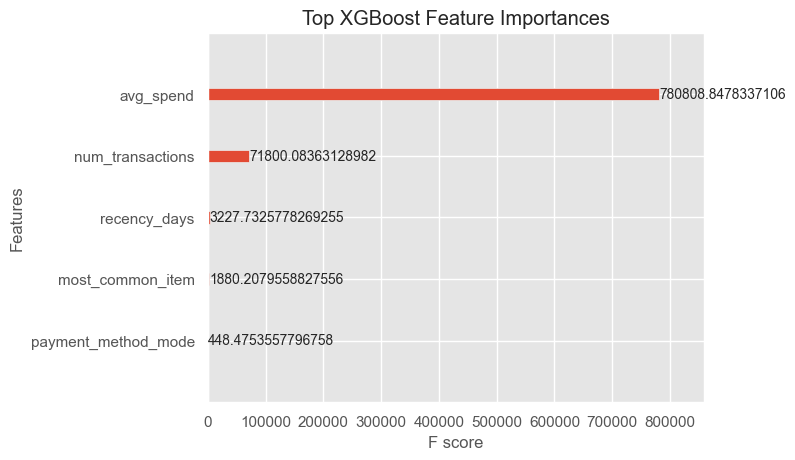

In [196]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plt.figure(figsize=(10,6))
plot_importance(best_xgb, importance_type='gain', max_num_features=10)
plt.title("Top XGBoost Feature Importances")
plt.show()

In [201]:
import joblib

joblib.dump(best_ridge, "../models/final_ridge_model.pkl")
joblib.dump(best_xgb, "../models/final_xgb_model.pkl")

# Save the scaler
joblib.dump(scaler, "../models/scaler.pkl")
print("Models saved successfully.")

Models saved successfully.


> Conclusion:
 
Ridge Regression delivered the lowest RMSE, indicating customer-level aggregated features are best modeled linearly. XGBoost also performed competitively and can be used for interpreting feature interactions. We will move forward using these two models to support predictive insights and dashboard integrations.

In [150]:
# # 7. Modeling – Classification
# print("\nTraining LogisticRegression...")
# clf_model = LogisticRegression()
# clf_model.fit(X_train_clf, y_train_clf)

# y_pred_clf = clf_model.predict(X_test_clf)

# print("\nClassification Report:")
# print(classification_report(y_test_clf, y_pred_clf))

# # 8. Confusion Matrix
# conf_matrix = confusion_matrix(y_test_clf, y_pred_clf)
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
# plt.title("Confusion Matrix")
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.show()